In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split



In [10]:
data=[]
with open("E:\EdgeAi\WISDM_ar_latest\WISDM_ar_v1.1\WISDM_ar_v1.1_raw.txt",'r')as file:
    for line in file:
        parts=line.strip().split(',')
        if len(parts)==6:
            try:
                user=int(parts[0])
                activity=parts[1]
                timestamp=int(parts[2])
                x=float(parts[3])
                y=float(parts[4])
                z_str = parts[5].replace(';', '')    
                z = float(z_str)
                data.append([user, activity, timestamp, x, y, z])
            except:
                continue      

df=pd.DataFrame(data, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])

df.to_csv('wisdm_cleaned.csv', index=False)
df.head(20)

    
      
 

,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062


Unique Activities: ['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']
Dataset Shape: (1086465, 6)


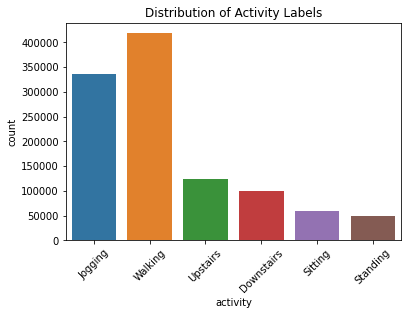

In [11]:

print("Unique Activities:", df['activity'].unique())
print("Dataset Shape:", df.shape)

# شمارش داده‌ها به ازای هر فعالیت
sns.countplot(data=df, x='activity')
plt.xticks(rotation=45)
plt.title("Distribution of Activity Labels")
plt.show()


In [12]:
#add Magnitude feature
df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)


In [13]:
df

,user,activity,timestamp,x,y,z,magnitude
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,12.709551
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,12.365693
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,11.936562
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,18.751973
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,14.139804
...,...,...,...,...,...,...,...
1086460,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,9.290910
1086461,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,9.319125
1086462,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,9.338463
1086463,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,9.280329


In [14]:
#Convert activity to activity_code(string to int)
le = LabelEncoder()
df['activity_code'] = le.fit_transform(df['activity'])

df

,user,activity,timestamp,x,y,z,magnitude,activity_code
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,12.709551,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,12.365693,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,11.936562,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,18.751973,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,14.139804,1
...,...,...,...,...,...,...,...,...
1086460,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,9.290910,2
1086461,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,9.319125,2
1086462,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,9.338463,2
1086463,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,9.280329,2


In [15]:

window_size = 100  
step_size = 20

segments = []
labels = []

for start in range(0, len(df) - window_size, step_size):
    end = start + window_size
    segment = df.iloc[start:end]
#فیلتر کردن پنجره‌هایی که فقط یک فعالیت دارند
    if len(segment['activity_code'].unique()) == 1:
        x = segment['x'].values
        y = segment['y'].values
        z = segment['z'].values
        magnitude = segment['magnitude'].values

        segments.append([x, y, z, magnitude])
        labels.append(segment['activity_code'].iloc[0])

# تبدیل به numpy
segments = np.asarray(segments)
labels = np.asarray(labels)

# تغییر شکل به (samples, timesteps, features)
X = np.transpose(segments, (0, 2, 1))  # (num_samples, 60, 4)
y = labels


In [16]:
scaler = StandardScaler()
num_samples, timesteps, num_features = X.shape

# اعمال استانداردسازی روی هر ویژگی
X_reshaped = X.reshape(-1, num_features)
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, timesteps, num_features)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [19]:
# تعداد کلاس‌ها
num_classes = len(np.unique(y_train))

# تبدیل y به one-hot
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


In [20]:
model = Sequential()

# لایه Conv1D
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Flatten و Dense
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


C:\Users\sheydameh\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [22]:
history = model.fit(X_train, y_train_cat,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test_cat))


Epoch 1/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7195 - loss: 0.7659 - val_accuracy: 0.8746 - val_loss: 0.3241
Epoch 2/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8510 - loss: 0.3930 - val_accuracy: 0.8929 - val_loss: 0.2584
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8742 - loss: 0.3299 - val_accuracy: 0.9204 - val_loss: 0.2189
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8912 - loss: 0.2841 - val_accuracy: 0.9338 - val_loss: 0.1858
Epoch 5/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9023 - loss: 0.2550 - val_accuracy: 0.9446 - val_loss: 0.1657
Epoch 6/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9122 - loss: 0.2288 - val_accuracy: 0.9432 - val_loss: 0.1636
Epoch 7/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9186 - loss: 0.2141 - val_accuracy: 0.9566 - val_loss: 0.1335
Epoch 8/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9228 - loss: 0.1997 - val_ac

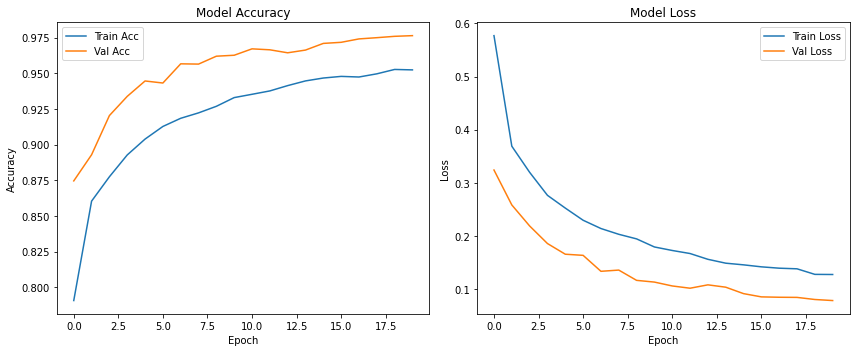

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# دقت
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# خطا
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
# 1. تبدیل مدل به TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 2. ذخیره مدل TFLite در فایل
with open("activity_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\SHEYDA~1\AppData\Local\Temp\tmpngtxy39g\assets


INFO:tensorflow:Assets written to: C:\Users\SHEYDA~1\AppData\Local\Temp\tmpngtxy39g\assets


Saved artifact at 'C:\Users\SHEYDA~1\AppData\Local\Temp\tmpngtxy39g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2082694745600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082694857472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082693857120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082693869808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082693964544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082693964192: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [25]:
import os
print("Current directory:", os.getcwd())


Current directory: C:\Users\sheydameh


In [61]:
# لود مفسر TFLite
interpreter = tf.lite.Interpreter(model_path="activity_model.tflite")
interpreter.allocate_tensors()

# گرفتن اطلاعات ورودی و خروجی
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# تست روی یک نمونه از داده تست
sample_input = X_test[0:1].astype(np.float32)  # فقط یه نمونه، float32 مهمه

interpreter.set_tensor(input_details[0]['index'], sample_input)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

print("Predicted probabilities:", output)
print("Predicted class:", np.argmax(output))


Predicted probabilities: [[6.1321858e-05 1.4062905e-04 3.0960469e-13 4.9982518e-20 1.1647191e-03
  9.9863333e-01]]
Predicted class: 5
